In [4]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 19.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 20.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.6/489.6 MB 3.9 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 17.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 20.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 12.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/46

In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import uncertainty_wizard as uwiz
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from tqdm.notebook import tqdm
from plot_keras_history import plot_history
import warnings
import pickle

In [6]:
with open('data.txt') as f:
    data=f.readlines()
data[1]=data[1].split(",")

In [7]:
EXPERIMENT_SIZE=int(data[1][0])
SAMPLE_SIZE =int(data[1][1])
percentage=float(data[1][2])
noise_budget =float(data[1][3])
T=int(data[1][4])
alpha=float(data[1][5])
beta=float(data[1][6])

In [8]:
warnings.filterwarnings('ignore')

In [9]:
class UncertaintyMaximization(Problem):
    def __init__(self,input_instance,y, epsilon,beta,alpha):
        super().__init__(n_var=X_train.shape[1],
                         n_obj=1,
                         n_constr=0,
                         elementwise_evaluation=True)
        self.input_instance = input_instance
        self.y = y
        self.epsilon = epsilon
        self.alpha=alpha
        self.beta=beta
    def _evaluate(self, noise, out, *args, **kwargs):
        prev_results = model.predict_quantified(self.input_instance,
                                       quantifier=quantifiers,
                                       batch_size=50000,
                                       sample_size=T,
                                       verbose=0)
        
        tmp_instance = self.input_instance + noise
        results = model.predict_quantified(tmp_instance,
                                       quantifier=quantifiers,
                                       batch_size=50000,
                                       sample_size=T,
                                       verbose=0)
        unc = results[0][1][0]
        y_hat = results[0][0][0]
        f1 = self.alpha/(0.0000001 + unc) + 0.01 * np.linalg.norm(noise) + self.beta * (np.int(self.y)==np.int(y_hat))
        g1 = np.linalg.norm(noise, ord=np.inf) - self.epsilon
        out["F"] = np.column_stack([f1])
        out["G"] = np.column_stack([g1])
        
        #print('U1:', prev_results[0][1][0],'U2:', unc,'Obj:',f1)
def get_bounds(uncertainty_budget):
    distance = np.max(X_train) - np.min(X_train)
    b = (-1*distance*uncertainty_budget/2.0, distance*uncertainty_budget/2.0)

    bounds = [b for i in range(X_train.shape[1])]

    initial_noise = np.random.uniform(low=np.min(bounds),
                                      high=np.max(bounds),
                                      size=(X_train.shape[1],))

    return bounds,initial_noise
def get_model():
    model = uwiz.models.StochasticSequential()
    model.add(tf.keras.layers.Dense(100, activation='relu',input_dim=X_train.shape[1]))
    model.add(tf.keras.layers.Dropout(0.09))
    model.add(tf.keras.layers.Dense(200, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.09))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'],run_eagerly=True)
    return model
def generate_instances(beta,alpha,noise_budget = 0.05, sample_size = 10):#beta=0.1,alpha=0.1):
    bounds,initial_noise = get_bounds(noise_budget)
    prev_unc_list = []
    unc_list = []
    prev_pred_list = []
    pred_list = []
    noise_norm = []
    org_x = []
    perturbated_x = []
    original_y = []
    input_norm = []
    selected_idx = []
    y_tmp_onehot_list = []

    for j in tqdm(range(sample_size)):
        #i = np.random.randint(0,X_train.shape[0],1)[0]
        i=j
        #print('i',i)
        selected_idx.append(i)
        x_tmp = np.array([X_train[i,:],])
        y_tmp = y_train[i].argmax()
        y_tmp_onehot = y_train[i]

        prev_results = model.predict_quantified(x_tmp,
                                               quantifier=quantifiers,
                                               batch_size=50000,
                                               sample_size=30,
                                               verbose=0)
        problem = UncertaintyMaximization(input_instance=x_tmp,
                                          y=y_tmp,
                                          epsilon=noise_budget,alpha=alpha,beta=beta)
        problem.xl = np.ones((x_tmp.shape[1],)) * np.min(bounds)
        problem.xu = np.ones((x_tmp.shape[1],)) * np.max(bounds)

        algorithm = NSGA2(
                            pop_size=40,
                            n_offsprings=10,
                            sampling=get_sampling("real_random"),
                            crossover=get_crossover("real_sbx", prob=0.9, eta=15),
                            mutation=get_mutation("real_pm", eta=20),
                            eliminate_duplicates=True
                        )

        res = minimize(problem,
                       algorithm,
                       ("n_gen", 10),
                       verbose=False)

        ##############################
        ###     Noise generated    ###
        ##############################

        res1 = model.predict_quantified(x_tmp,
                                               quantifier=quantifiers,
                                               batch_size=50000,
                                               sample_size=T,
                                               verbose=0)
        x_tmp_noisy = x_tmp + res.X

        results = model.predict_quantified(x_tmp_noisy,
                                           quantifier=quantifiers,
                                           batch_size=50000,
                                           sample_size=T,
                                           verbose=0)
        #print('U1:', res1[0][1][0],'U2:', results[0][1][0])
        prev_unc_list.append(prev_results[0][1][0])
        prev_pred_list.append(prev_results[0][0][0].astype(int))

        unc_list.append(results[0][1][0])
        pred_list.append(results[0][0][0].astype(int))

        noise_norm.append(np.linalg.norm(res.X))
        input_norm.append(np.linalg.norm(x_tmp))
        original_y.append(y_tmp)
        y_tmp_onehot_list.append(y_tmp_onehot)

        org_x.append(x_tmp)
        perturbated_x.append(x_tmp_noisy)

    df = pd.DataFrame({'idx':selected_idx,'y':original_y,
                       'y_hat':prev_pred_list,'y_hat2':pred_list,
                       'unc_init':prev_unc_list,'unc_pert':unc_list,
                       'input_norm':input_norm,'noise_norm':noise_norm
                    })
    np.savez(f'train_test_{alpha}_{beta}-' + str(noise_budget) + '.npz',
                     X_train=X_train, X_test=X_test, y_train=y_train,
                     y_test=y_test, org_x=org_x, perturbated_x=perturbated_x,
                     original_y=original_y,prev_pred_list=prev_pred_list,
                     pred_list=pred_list,y_tmp_onehot_list=y_tmp_onehot_list)
    df.to_csv(f'manipulated_instances_{alpha}_{beta}.csv',index=False)
    return df

In [12]:
# demonstrate data normalization with sklearn
# load data
data = ...
# create scaler
scaler = MinMaxScaler()
infileX = open("/datasets/xy/X",'rb')
X = pickle.load(infileX)
infiley = open("/datasets/xy/y",'rb')
y = pickle.load(infiley)
length=int(len(X)*percentage)
Xs=X[:length]
Ys=y[:length]
print(len(Ys))
X_train, X_test, y_train, y_test = train_test_split(Xs, Ys,
                                                    test_size=0.33, random_state=27)
quantifiers = ['pred_entropy']
model = get_model()

245818


2022-07-06 19:04:38.826171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 19:04:38.832827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-07-06 19:04:38.833717: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-07-06 19:04:38.833740: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if 

2022-07-06 19:04:39.370480: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 324155520 exceeds 10% of free system memory.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9037
           1       0.00      0.00      0.00      9098
           2       0.00      0.00      0.00      8853
           3       0.04      0.07      0.05      9062
           4       0.00      0.00      0.00      9020
           5       0.14      0.24      0.18      9141
           6       0.06      0.33      0.10      8909
           7       0.00      0.00      0.00      9052
           8       0.00      0.00      0.00      8948

    accuracy                           0.07     81120
   macro avg       0.03      0.07      0.04     81120
weighted avg       0.03      0.07      0.04     81120

**************************************************


  0%|          | 0/1 [00:00<?, ?it/s]


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False



2022-07-06 19:05:09.879226: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 651555792 exceeds 10% of free system memory.


Epoch 00008: early stopping


2022-07-06 19:05:29.800812: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 324155520 exceeds 10% of free system memory.


beta:  0.3    alpha:   0.9


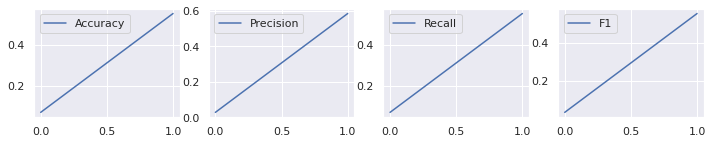

In [13]:
### Generate instances
tf.config.run_functions_eagerly(True)
y_hat = model.predict(X_test)
cr = classification_report(y_test.argmax(axis=1),y_hat.argmax(axis=1))
print(cr)
print('*'*50)
prec_list = []
recall_list = []
f1_list = []
acc_list = []

prec_list.append(precision_score(y_test.argmax(axis=1),y_hat.argmax(axis=1),average='weighted'))
recall_list.append(recall_score(y_test.argmax(axis=1),y_hat.argmax(axis=1),average='weighted'))
f1_list.append(f1_score(y_test.argmax(axis=1),y_hat.argmax(axis=1),average='weighted'))
acc_list.append(accuracy_score(y_test.argmax(axis=1),y_hat.argmax(axis=1)))


es_unc = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

model.inner.load_weights('model.hdf5')

for _ in range(EXPERIMENT_SIZE):
    df = generate_instances(noise_budget = noise_budget, sample_size=T,beta=beta,alpha=alpha)
    idx = df.idx.values
    if len(idx) > 0:
        load_data = np.load(f'train_test_{alpha}_{beta}-' + str(noise_budget) + '.npz')
        perturbated_x = load_data['perturbated_x']
        original_y = load_data['original_y']
        X_train = load_data['X_train']
        y_train = load_data['y_train']
        X_test = load_data['X_test']
        y_test = load_data['y_test']
        y_tmp_onehot_list = load_data['y_tmp_onehot_list']

        perturbated_x = perturbated_x.reshape((perturbated_x.shape[0],perturbated_x.shape[2]))

        new_X_train = np.concatenate((X_train, perturbated_x), axis=0)
        new_y_train = np.concatenate((y_train, y_tmp_onehot_list), axis=0)
        hist = model.fit(new_X_train, new_y_train, validation_split=0.01,
                         batch_size=5000,epochs=10,verbose=0,callbacks=[es_unc])

        y_hat = model.predict(X_test)


    prec_list.append(precision_score(y_test.argmax(axis=1),y_hat.argmax(axis=1),average='weighted'))
    recall_list.append(recall_score(y_test.argmax(axis=1),y_hat.argmax(axis=1),average='weighted'))
    f1_list.append(f1_score(y_test.argmax(axis=1),y_hat.argmax(axis=1),average='weighted'))
    acc_list.append(accuracy_score(y_test.argmax(axis=1),y_hat.argmax(axis=1)))
print("beta: ",beta,"   alpha:  ",alpha)
sns.set()
f, ax = plt.subplots(1,4, figsize=(12, 2))
ax[0].plot(acc_list,label='Accuracy')
ax[1].plot(prec_list,label='Precision')
ax[2].plot(recall_list,label='Recall')
ax[3].plot(f1_list,label='F1')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
plt.savefig(f'Accuracy_Precision_Recall_{alpha}_{beta}.png')

In [14]:
robust_predictions_train = model.predict_quantified(X_train,
                                                   quantifier=quantifiers,
                                                   batch_size=50000,
                                                   sample_size=T,
                                                   verbose=0)
robust_predictions_test = model.predict_quantified(X_test,
                                                   quantifier=quantifiers,
                                                   batch_size=50000,
                                                   sample_size=T,
                                                   verbose=0)

2022-07-06 19:05:41.146071: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1316266416 exceeds 10% of free system memory.
2022-07-06 19:05:42.212233: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1316266416 exceeds 10% of free system memory.


Epoch 00026: early stopping


2022-07-06 19:07:04.965332: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://ac50f4b6-b7a2-40e3-aebc-8d605c1cdf7c/assets


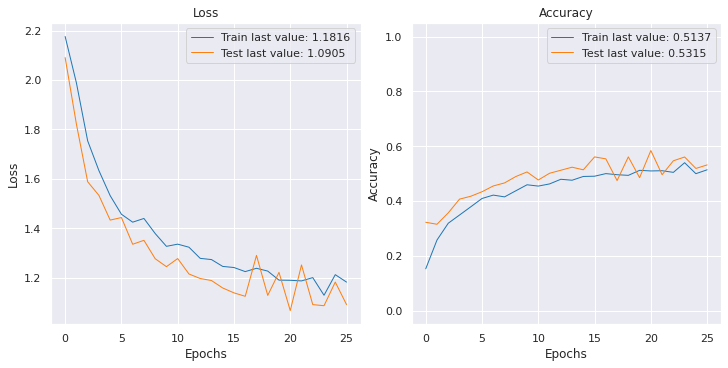

In [15]:
# 2. Adversarial Machine Learning based Test Input Generation

adv_model = get_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

hist = adv_model.fit(X_train, y_train, validation_split=0.3, batch_size=5000,
                     epochs=200, verbose=0, callbacks=[es])

init_predictions_train = adv_model.predict_quantified(X_train,
                                                   quantifier=quantifiers,
                                                   batch_size=50000,
                                                   sample_size=T,
                                                   verbose=0)
init_predictions_test = adv_model.predict_quantified(X_test,
                                                   quantifier=quantifiers,
                                                   batch_size=50000,
                                                   sample_size=T,
                                                   verbose=0)


with open('{alpha}_{beta}.pickle', 'wb') as handle:
    pickle.dump(hist, handle)
plot_history(hist)
plt.savefig(f'hist_{alpha}_{beta}.png')
adv_model.inner.load_weights('model.hdf5')

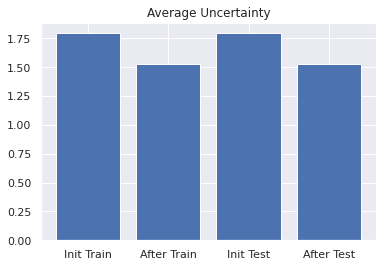

In [16]:
axes = ['Init Train', 'After Train','Init Test','After Test']
vals = [np.mean(init_predictions_train[0][1]),np.mean(robust_predictions_train[0][1]),
        np.mean(init_predictions_test[0][1]),np.mean(robust_predictions_test[0][1]) ]
plt.bar(axes,vals)
plt.title('Average Uncertainty')
plt.savefig(f'Average Uncertainty_{alpha}_{beta}.png')

In [17]:
norm = np.inf

#model.inner.load_weights('model.hdf5')

es_adv = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

logits_model = tf.keras.Model(adv_model.inner.input, adv_model.inner.layers[-1].output)

y_hat = adv_model.predict(X_test)

adv_prec_list = []
adv_recall_list = []
adv_f1_list = []
adv_acc_list = []

adv_prec_list.append(precision_score(y_test.argmax(axis=1),y_hat.argmax(axis=1),average='weighted'))
adv_recall_list.append(recall_score(y_test.argmax(axis=1),y_hat.argmax(axis=1),average='weighted'))
adv_f1_list.append(f1_score(y_test.argmax(axis=1),y_hat.argmax(axis=1),average='weighted'))
adv_acc_list.append(accuracy_score(y_test.argmax(axis=1),y_hat.argmax(axis=1)))

for i in tqdm(range(EXPERIMENT_SIZE)):
    perturbated_x = fast_gradient_method(logits_model, X_train[0:SAMPLE_SIZE,:], noise_budget,
                                               norm, targeted=False)

    new_X_train = np.concatenate((X_train, perturbated_x), axis=0)
    new_y_train = np.concatenate((y_train, y_train[0:SAMPLE_SIZE]), axis=0)

    model.inner.load_weights('model.hdf5')
    
    hist = adv_model.fit(new_X_train, new_y_train, validation_split=0.3,
                         batch_size=5000,epochs=5,verbose=0,callbacks=[es_adv])
    
    y_hat = adv_model.predict(X_test)
        
    adv_prec_list.append(precision_score(y_test.argmax(axis=1),y_hat.argmax(axis=1),average='weighted'))
    adv_recall_list.append(recall_score(y_test.argmax(axis=1),y_hat.argmax(axis=1),average='weighted'))
    adv_f1_list.append(f1_score(y_test.argmax(axis=1),y_hat.argmax(axis=1),average='weighted'))
    adv_acc_list.append(accuracy_score(y_test.argmax(axis=1),y_hat.argmax(axis=1)))

  0%|          | 0/1 [00:00<?, ?it/s]

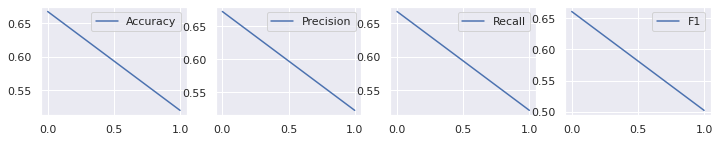

In [18]:
sns.set()
f, ax = plt.subplots(1,4, figsize=(12, 2))
ax[0].plot(adv_acc_list,label='Accuracy')
ax[1].plot(adv_prec_list,label='Precision')
ax[2].plot(adv_recall_list,label='Recall')
ax[3].plot(adv_f1_list,label='F1')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
plt.savefig(f'Accuracy_Precision_Recall_2{alpha}_{beta}.png')

In [19]:
adv_robust_predictions_train = adv_model.predict_quantified(X_train,
                                                   quantifier=quantifiers,
                                                   batch_size=50000,
                                                   sample_size=T,
                                                   verbose=0)
adv_robust_predictions_test = adv_model.predict_quantified(X_test,
                                                   quantifier=quantifiers,
                                                   batch_size=50000,
                                                   sample_size=T,
                                                   verbose=0)

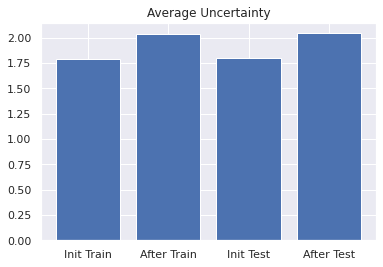

In [20]:
axes = ['Init Train', 'After Train','Init Test','After Test']
vals = [np.mean(init_predictions_train[0][1]),np.mean(adv_robust_predictions_train[0][1]),
        np.mean(init_predictions_test[0][1]),np.mean(adv_robust_predictions_test[0][1]) ]
plt.bar(axes,vals)
plt.title('Average Uncertainty')
plt.savefig(f'Average Uncertainty_2{alpha}_{beta}.png')